# Star Galaxy

Ningyi Liao

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
 {
    display: table-cell;
    text-align: center;
   .output_png vertical-align: middle;
}
</style>
""")

# Introduction
---

## Research Background

Discriminating between stars and galaxies is a classic topic that dates back to Charles Messier’s time. As astronomical observation technology develops, an unprecedentedly large number of objects have been discovered, exceeding the ability of any human to process manually. Hence, it is more essential than ever to develop automated methods on data analysis to perform the task efficiently and accurately. 

Telling stars and galaxies apart, or the Star/Galaxy Separation Problem (SGSP), is important, for being one of the first steps in processing observation data. It is only after correct separation that the following categorizing and analyzing technique would be effective. However, SGSP also remains as one of the most difficult tasks. For distant and dim objects, the difference between stars and galaxies becomes fuzzier, making it hard to discriminate simply with human eyes. In addition, many factors, including equipment resolution, imaging quality, and artifacts, will lead to even poorer separation results ([*Machado et al. (2016)*](https://ieeexplore.ieee.org/document/7727189)). 

In the process of development, researchers apply different methods on SGSP. One of the main aspects is machine learning models, for their good performance as well as automated features. [*Odewahn et al. (1992)*](https://link.springer.com/chapter/10.1007/978-94-011-2472-0_28) first explored the possibility of automated algorithms using artificial neural networks, creating a fundamental precedent on this field. One of the example using neural networks is the popular astronomical image processing software SExtractor ([*Bertin & Arnouts 1996*](https://aas.aanda.org/articles/aas/ps/1996/08/ds1060.ps.gz)). Researchers also look into other machine learning approaches. [*Weir, Fayyad, & Djorgovski (1995)*](http://adsabs.harvard.edu/full/1995AJ....109.2401W) applied the decision trees method on large scale sky surveys data. In 2004, support vector machines is also implemented on SGSP ([*Zhang & Zhao*](https://www.aanda.org/articles/aa/abs/2004/30/aa3942/aa3942.html)). Recently, more advanced neural networks techniques are introduced thanks to the trend of deep learning ([*Kamdar, Turk, & Brunner 2015*](https://academic.oup.com/mnras/article-abstract/455/1/642/984981), [*Kim & Brunner 2016*](https://academic.oup.com/mnras/article-abstract/464/4/4463/2417400)). In 2016, [*Machado et al.*](https://ieeexplore.ieee.org/document/7727189) conducted a comparison study on different SGSP machine learning methods. 

One of the common phenomenon is that, most SGSP solutions include, or mainly depend on the object attributes of spectroscopic data. This is effective for higher accuracy, as spectrum contains more information about the actual object. However it limits the scope of usage, that such algorithms would be inconvenient and impractical when there is no spectra available, due to either equipment or data limitations. This is especially a common case in amateur observation and photography. 

There is also controversy on applying analytical methods in machine learning models according to some researchers ([*Kim & Brunner 2016*](https://academic.oup.com/mnras/article-abstract/464/4/4463/2417400)). They criticize that excessive intervention on the observation data not only requires abundant expert knowledge, but may also bring in bias. It is better and more general to enable the algorithm learning data features by itself. In the most straightforward form, it means to learn directly from the image pixels. 

In this work, we focus on the context that using images only and directly as the input data. We search for the optimal hyper parameters of different supervised machine learning classifiers and train them on the data to solve the SGSP task. We then measure experiment performance of each models and look into the relationship between separation accuracy and object magnitude. 

## Data Processing

In this paper, we use a subset from the Sloan Digital Sky Survey Data Release 15, or the SDSS DR15 ([*Aguado et al. 2019*](https://iopscience.iop.org/article/10.3847/1538-4365/aaf651/meta)). Being one of the largest sky survey, the SDSS database contains five bands color information and other attributes of more than 300 million stars and galaxies ([*York et al. 2000*](https://iopscience.iop.org/article/10.1086/301513)). All the photometric and spectroscopic data is publicly [available online](https://www.sdss.org/dr15/data_access). 

To acquire the data, we use the [SDSS SQL Search](http://skyserver.sdss.org/dr15/en/tools/search/sql.aspx) to query the object coordinates, magnitude, and type information. According to previous research ([*Machado et al. 2016*](https://ieeexplore.ieee.org/document/7727189)), the density of stars and galaxies in the dataset is correlated with their magnitude, which may bring additional information into classifiers and have influence on the separation. Hence we set the limit to $1,000$ of each star/galaxy visual magnitude ([*Jester et al. 2005*](http://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jester2005)) range width $1.0$. The query magnitude range is from $15.0$ to $20.0$, forming a database subset of $10,000$ samples in total. As the query order is base on the attribute `id` of object, it can be seen as a random sampling subset. Other constraints include the `score` and `CLEAN` attributes mainly for the image quality. We also exclude QSOs, for the reason that identifying them should be a more specific problem base on their distinct characteristic. 

Base on the queries information, we then use the [SDSS Image Cutout API](http://skyserver.sdss.org/dr15/en/help/docs/api.aspx#imgcutout) to download $10,000$ images of corresponding objects. All the image data in our study are images of RGB color and in JPG format. This is one of the most common image formats, offering our models a wide applicability on the model data source, especially in the situation where RGB images are the only available input for a SGSP task. The images are cutouts of a single galaxy or star at the center base on their celestial coordinates. The resolution is $32 \times 32$ pixels, at the scale of $0.4''/\mathrm{px}$. We use the relatively low resolution for two reasons. First, dim objects are often small on images, which is the difficult case for most SGSP classifiers. Also, a smaller data size provides an efficient model training process, and may also maintain generality on higher resolution data.  

To use the images as input data, we flatten the three channel image array to one-dimension feature vectors. Thus each pixel is calculated as one feature to the model input. We use the labeling data of `STAR` or `GALAXY` as target classes. 

The data processing procedure is executed and can be deeper reviewed in the IPython Notebook [`data.ipynb`](data.ipynb). In this notebook, the data are provided by following functions. 

In [3]:
%pylab inline

import warnings;
warnings.filterwarnings('ignore');

import numpy as np
import pandas as pd
import sklearn.model_selection, sklearn.metrics

Populating the interactive namespace from numpy and matplotlib


In [4]:
def load_data(fname):
    '''Load label and image data of given magnitude.'''
    path_qry, path_arr = "../data/query/", "../data/array/"
    fname = str(fname)

    f_g, f_s = pd.read_csv(path_qry + "g" + fname + ".csv"), pd.read_csv(path_qry + "s" + fname + ".csv")
    d_g, d_s = np.load(path_arr+ "g"  + fname + ".npy"), np.load(path_arr+ "s"  + fname + ".npy")
#     print(d_s.shape, d_s[0, 0, 0, :])

    f = f_g.append(f_s)
    d = np.vstack((d_g, d_s))

    # shuffle order
    np.random.seed(42)
    pm = np.random.permutation(d.shape[0])
    f, d = f.iloc[pm, :], d[pm]
#     print(len(d), d[0, 0, 0, :])
    return f, d
    
def load_data_all(left=15, righ=20):
    '''Load the dataset of given magnitude range.'''
    path_qry, path_arr = "../data/query/", "../data/array/"
    for fname in range(left, righ):
        fname = str(fname)

        f_g, f_s = pd.read_csv(path_qry + "g" + fname + ".csv"), pd.read_csv(path_qry + "s" + fname + ".csv")
        d_g, d_s = np.load(path_arr + "g"  + fname + ".npy"), np.load(path_arr + "s"  + fname + ".npy")

        if fname == str(left):
            f = f_g.append(f_s)
            d = np.vstack((d_g, d_s))
        else:
            f = f.append(f_g)
            f = f.append(f_s)
            d = np.vstack((d, d_g, d_s))
            
    # shuffle order
    np.random.seed(42)
    pm = np.random.permutation(d.shape[0])
    f, d = f.iloc[pm, :], d[pm]
#     print('shape:', len(d), d[0, 0, 0, :])
    return f, d

def load_sample(f, d, random_state=None, test_size=0.25):
    '''Generate random training and testing samples from labels and images.'''
    x = d.reshape((len(d), -1))
    y = (f['type'] == 3).values  # GALAXY for True, STAR for False

    x_tr, x_ts, y_tr, y_ts = sklearn.model_selection.train_test_split(x, y, 
                                                                      test_size=test_size, 
                                                                      random_state=random_state)

#     print('shape:', x.shape, y.shape, x_tr.shape, y_ts.shape)
    return x_tr, x_ts, y_tr, y_ts

Here are examples of the input data images. 

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc

rc('text', usetex=True)
rc('font', family='Times New Roman')

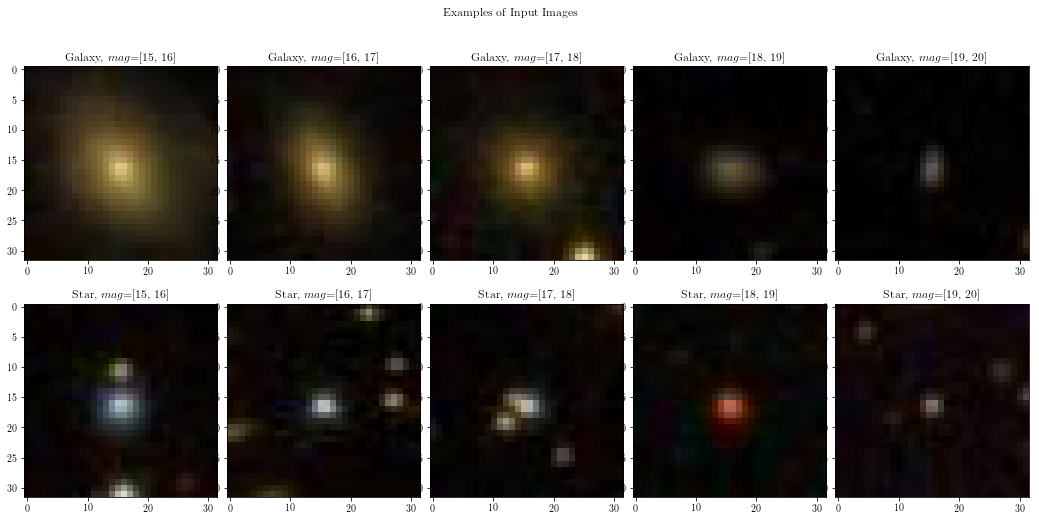

In [6]:
# prepare figure
fig, axs = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(hspace = 0.2, wspace = 0.05)
fig.suptitle('Examples of Input Images')

for m in range(15, 20):
    path_qry, path_arr = "../data/query/", "../data/array/"
    fname = str(m)
    d_g, d_s = np.load(path_arr + "g"  + fname + ".npy"), np.load(path_arr + "s"  + fname + ".npy")
    img_g, img_s = d_g[42, :].astype(uint8), d_s[42, :].astype(uint8)
    
    axs[0, m-15].imshow(img_g)
    axs[0, m-15].set_title('Galaxy, $mag$=[%d, %d]' % (m, m+1))
    
    axs[1, m-15].imshow(img_s)
    axs[1, m-15].set_title('Star, $mag$=[%d, %d]' % (m, m+1))

# Classifiers and Parameter Exploration
---

In this work, we apply five mainstream machine learning classification methods using the Python package scikit-learn ([`sklearn`](https://scikit-learn.org/stable/index.html)). We utilize the [`sklearn.model_selection.GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method to optimize hyper-parameters of each model with cross-validation. Note that we keep the random state parameter to `None` in order to explore a wider range of models states.  

All exploratory trainings run on a $2,000$-image random sample from the full dataset. 

In [7]:
path_qry, path_arr, fname = "../data/query/", "../data/array/", "sample"
f = pd.read_csv(path_qry + fname + ".csv")
d = np.load(path_arr + fname + ".npy")
x_tr, x_ts, y_tr, y_ts = load_sample(f, d)

To measure the training performance, we use the accuracy $A$ of each classifier defined as: 
$$
A = \frac{T_g + T_s}{T_g + T_s + F_g + F_s}
$$
where, $T_g$ and $T_s$ are the number of successfully classified galaxies and stars respectively, $F_g$ is the number of true galaxies classified as stars, and $F_s$ is number of true stars classified as galaxies. 

To evaluate the models, we also introduce another common metrics in classification problems ([*Machado et al. 2016*](https://ieeexplore.ieee.org/document/7727189)), the completeness $C$ and purity $P$, which are expressed on the galaxy side by: 
$$
C = \frac{T_g}{T_g + F_g} \\
P = \frac{T_g}{T_g + F_s}
$$

The higher $C$ represents more galaxies samples are successfully identified, and the higher $P$ value indicates more confidence that the classified galaxies objects are true galaxies. 

In [8]:
def metric(confusion_matrix):
    '''The metrics from a given confusion matrix.'''
    Tg, Ts = confusion_matrix[1, 1], confusion_matrix[0, 0]
    Fg, Fs = confusion_matrix[1, 0], confusion_matrix[0, 1]
    A = (Tg + Ts) / (Tg + Ts + Fg + Fs) * 100
    C = Tg / (Tg + Fg) * 100
    P = Tg / (Tg + Fs) * 100
    return A, C, P

def search_param(classifier, param_grid):
    '''Grid search and cross-validate optimal paragrams for presentation.'''
    # in real search the `cv` should be at least 5 for better accuracy (but slower search)
    clf = sklearn.model_selection.GridSearchCV(classifier, param_grid, cv=2, iid=False, n_jobs=2)
    clf = clf.fit(x_tr, y_tr)
    clf_best = clf.best_estimator_
    
    # calculate metrics on testing data fold
    y_pred = clf_best.predict(x_ts)
    A, C, P = metric(sklearn.metrics.confusion_matrix(y_ts, y_pred, labels=range(2)))
    
    print('Best estimator =', clf.best_estimator_)
    print('A = %0.2f%%, C = %0.2f%%, P = %0.2f%%' % (A, C, P))

## Support Vector Machines

Support Vector Machines (SVM) are machine learning models that use kernels to classify samples in a high dimensional feature space with supporting vectors. SVM has been successfully applied in many astronomical problems ([*Zhang & Zhao 2004*](https://www.aanda.org/articles/aa/abs/2004/30/aa3942/aa3942.html), [*Fadely, Hogg, & Willman 2012*](https://iopscience.iop.org/article/10.1088/0004-637X/760/1/15/meta)). SVM requires careful parameters adjustment base on different input data, but often presents good results if suitable. 

Our SVM is based on the package [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). Here we implement SVM with the $rbf$ kernel. We mainly look into two major SVM parameters, $C$ and $\mathrm{gamma}$ within the range $0.1 \le C \le 1000$ and $10^{-7} \le \mathrm{gamma} \le 0.1$. We conduct careful search and decide the best value of $C = 5$, $\mathrm{gamma} = 2\times10^{-6}$. Here is a simplified search procedure which intends to show the process but does not guarantee optimal parameters.

In [9]:
import sklearn.svm

classifier = sklearn.svm.SVC(kernel='rbf', class_weight='balanced')
param_grid = {'C': [0.1, 5, 100, 1000],  
              'gamma': [1e-6, 2e-6, 1e-4, 0.1]}

search_param(classifier, param_grid)

Best estimator = SVC(C=5, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
A = 98.40%, C = 97.59%, P = 99.18%


## k-Nearest Neighbors

k-Nearest Neighbors (kNN) classifier implements the k-Nearest Neighbors algorithm to decide border and vote each input into one of the neighbors. kNN is suitable for complex input distribution and shares generality on different problem settings ([*Goldberger et al. 2005*](https://cs.nyu.edu/~roweis/papers/ncanips.pdf)). 

We take the [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) as our kNN method. The most important parameter in the model is the number of neighbors $k$, that a large $k$ classifier is lack of variance between classes, while few neighbors ignore some data detail information. We explore the range of $1 \le k \le 500$ to find the best value $k = 10$. 

In [10]:
import sklearn.neighbors

classifier = sklearn.neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': [1, 10, 100, 500]}

search_param(classifier, param_grid)

Best estimator = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')
A = 96.40%, C = 96.39%, P = 96.39%


## Decision Tree Classifier

The Decision Tree Classifier (DTC) builds a binary tree to look into data features and categorize input. It is easy to establish, but still remains useful on complex or large dataset. It is also a basic supervised machine learning method that gives interpretable results ([*Breiman et al. 1984*](https://content.taylorfrancis.com/books/download?dac=C2009-0-07054-X&isbn=9781351460491&format=googlePreviewPdf)). Decision Trees has been introduced to SGSP due to its robust performance ([*Ball et al. 2006*](https://iopscience.iop.org/article/10.1086/507440)). 

The method [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) provides a well-prepared DTC. We continue from Ball's work, use the criterion of `entropy`, and mainly explore attributes of $\mathrm{maximum\ tree\ depth}$ and $\mathrm{minimum\ leaf\ samples}$ in order to balance efficiency and accuracy. The optimization range is $4 \le \mathrm{maximum\ tree\ depth} \le 20$ and $1 \le \mathrm{minimum\ leaf\ samples} \le 16$. Search result is $\mathrm{maximum\ tree\ depth} = 4$, $\mathrm{minimum\ leaf\ samples} = 2$.

In [11]:
import sklearn.tree

classifier = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
param_grid = {'max_depth': [4, 8, 16, 20],  
              'min_samples_leaf': [1, 2, 4, 8, 16]  }

search_param(classifier, param_grid)

Best estimator = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
A = 95.60%, C = 93.98%, P = 97.10%


## Random Forest Classifier

The thought of Random Forest is to build a series of Decision Trees, hence forms the Random Forest Classifier (RFC), which uses a subset data to train a number of trees and calculate ensemble average for classes. Comparing with Decision Trees, the RFC tries to overcome the problems such as over-fitting, and provides a wider transferability. [*Gao, Zhang, & Zhao (2009)*](https://iopscience.iop.org/article/10.1088/1674-4527/9/2/011) also study the usage of RFC in astronomical context. 

In this paper we use the [`sklearn.ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier). We search for the key hyper-parameter of Decision Trees number $n$ with the range $100 \le n \le 500$. We reach the result of $n = 350$. 

In [12]:
import sklearn.ensemble

classifier = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators': [100, 200, 350, 500]}

search_param(classifier, param_grid)

Best estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
A = 97.60%, C = 95.98%, P = 99.17%


## Gaussian Naive Bayes

The Gaussian Naive Bayes (GNB) is an extension of naive Bayes classifying method. It assumes a Gaussian distribution of the input data to carry Naive Bayes, that calculate the label category base on conditional probabilities from the dataset. The Naive Bayes and GNB are basic and simple solutions to categorical data with a wide range of usage ([*Chan, Golub, & LeVeque 1979*](http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf)). 

We directly use the [`sklearn.naive_bayes.GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB). There is no parameter to set. 

In [13]:
import sklearn.naive_bayes

classifier = sklearn.naive_bayes.GaussianNB()
param_grid = {}

search_param(classifier, param_grid)

Best estimator = GaussianNB(priors=None, var_smoothing=1e-09)
A = 69.60%, C = 50.20%, P = 81.70%


The parameter optimization results are displayed in the following table:

|  Model  |             Parameters            |  Parameters Range  |     Optimal Result    |
|:-------:|:---------------------------------:|:------------------:|:---------------------:|
| **SVM** |                $C$                |    $[0.1, 1000]$   |          $5$          |
| **SVM** |          $\mathrm{gamma}$         |  $[10^{-7}, 0.1]$  |   $2\times 10^{-6}$   |
| **kNN** |                $k$                |     $[1, 500]$     |         $10$          |
| **DTC** |  $\mathrm{maximum\ tree\ depth}$  |      $[4, 20]$     |          $4$          |
| **DTC** | $\mathrm{minimum\ leaf\ samples}$ |      $[1, 16]$     |          $2$          |
| **RFC** |                $n$                |     $[100, 500]$   |         $350$         |
| **GNB** |                 -                 |          -         |           -           |

# Results
---

We then use each classifiers with optimal parameters to fit the full dataset and evaluate their performances. We also fit the classifiers on each dataset of magnitude groups, then use the trained models to predict labels on every magnitude groups, to look into the training transferability and model generality. To maintain the experiment comparabilit, we use the same data folds of $1,500$ training samples and $500$ testing oneach magnitude group. 

In [14]:
import sklearn.svm, sklearn.neighbors, sklearn.tree, sklearn.ensemble, sklearn.naive_bayes

clf_lst = [sklearn.svm.SVC(
               kernel='rbf', C=5, gamma=2e-6, 
               class_weight='balanced', degree=3, verbose=False), 
           sklearn.neighbors.KNeighborsClassifier(
               n_neighbors=10), 
           sklearn.tree.DecisionTreeClassifier(
               criterion='entropy', 
               max_depth=4, min_samples_leaf=2),
           sklearn.ensemble.RandomForestClassifier(
               n_estimators=350, verbose=False),
           sklearn.naive_bayes.GaussianNB()]
name_lst = ['SVM', 'kNN', 'DTC', 'RFC', 'GNB']

## Performance on Different Magnitude Groups

We study the model performance between diffierent datasets using a method called cross-prediction. For each model with optimal parameters, we first train it on one of the magnitude groups, then use the matrics $A$, $C$, and $P$ to evaluate prediction on all six groups to examine the model training transferability. Testing results on all six training groups forms a matrix for each metric, that demonstrate the model separation performance when the dataset is altered. 

The 

In [15]:
def cross_predict(clf):
    mat_metric = np.empty((6, 6, 3))

    for data_train in range(6):
        if data_train == 0:
            f, d = load_data_all()
        else:
            f, d = load_data(14 + data_train)
        x_tr, _, y_tr, _ = load_sample(f, d, random_state=42)

#         print('data_train =', data_train)
        clf.fit(x_tr, y_tr)

        for data_test in range(6):
            if data_test == 0:
                f, d = load_data_all()
            else:
                f, d = load_data(14 + data_test)
            _, x_ts, _, y_ts = load_sample(f, d, random_state=42)

            y_pred = clf.predict(x_ts)
            mat_metric[data_train, data_test, :] = \
                metric(sklearn.metrics.confusion_matrix(y_ts, y_pred, labels=range(2)))
    return mat_metric

In [16]:
mat_metric_lst = np.empty([5, 6, 6, 3])

for i in range(5):
    mat_metric = cross_predict(clf_lst[i])
    mat_metric_lst[i, :] = mat_metric

We then plot the generated matrixs. 

In [17]:
cmap = plt.cm.coolwarm_r
ctext = lambda x: 'w' if (x > 85 or x < 15) else (72/256,72/256,72/256)
label = ['[15, 20]'] + [('[%d, %d]' % (mag, mag+1)) for mag in range(15, 20)]

def plot_metrics(mat_metric, name):
    mat_a, mat_c, mat_p = mat_metric[:,:,0], mat_metric[:,:,1], mat_metric[:,:,2]
    fig, (ax_a, ax_c, ax_p) = plt.subplots(1, 3, figsize=(14.5, 4))
    fig.subplots_adjust(wspace = 0.2, hspace = 0.4)
    fig.suptitle('Cross-Prediction Results of ' + name, 
                 x=0.52, y=0.9999, fontweight='bold')

    # plot accuracy
    img_a = ax_a.imshow(mat_a, interpolation='nearest', 
                        cmap=cmap, vmin=0, vmax=100)
    # set labels
    ax_a.set(xticks=np.arange(6), yticks=np.arange(6),
             xticklabels=label, yticklabels=label,
             title='Cross-Prediction Accuracy',
             ylabel='Train Magnitude', xlabel='Test Magnitude')
    # set annotations 
    for i in range(6):
        for j in range(6):
            ax_a.text(j, i, format(mat_a[i, j], '0.1f'),
                      ha='center', va='center',
                      color=ctext(mat_a[i, j]))

    # plot completeness
    img_c = ax_c.imshow(mat_c, interpolation='nearest', 
                        cmap=cmap, vmin=0, vmax=100)
    # set labels
    ax_c.set(xticks=np.arange(6), yticks=np.arange(6),
             xticklabels=label, yticklabels=label,
             title='Cross-Prediction Completeness',
             ylabel='Train Magnitude', xlabel='Test Magnitude')
    # set annotations 
    for i in range(6):
        for j in range(6):
            ax_c.text(j, i, format(mat_c[i, j], '0.1f'),
                      ha='center', va='center',
                      color=ctext(mat_c[i, j]))

    # plot purity
    img_p = ax_p.imshow(mat_p, interpolation='nearest', 
                        cmap=cmap, vmin=0, vmax=100)
    ax_p.figure.colorbar(img_p, ax=ax_p)
    # set labels
    ax_p.set(xticks=np.arange(6), yticks=np.arange(6),
             xticklabels=label, yticklabels=label,
             title='Cross-Prediction Purity',
             ylabel='Train Magnitude', xlabel='Test Magnitude')
    # set annotations 
    for i in range(6):
        for j in range(6):
            ax_p.text(j, i, format(mat_p[i, j], '0.1f'),
                      ha='center', va='center',
                      color=ctext(mat_p[i, j]))

    fig.tight_layout()
    plt.show()

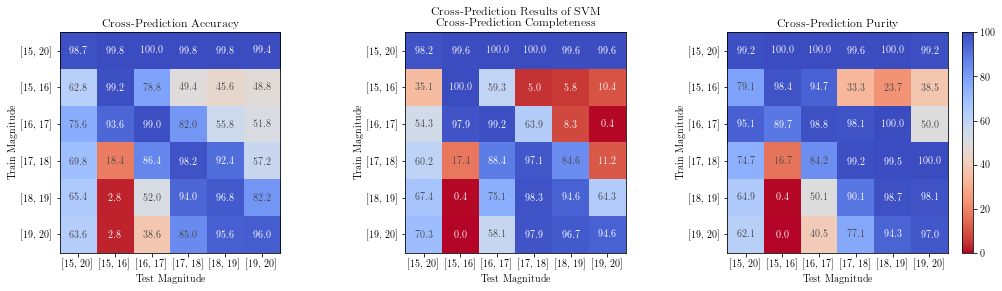

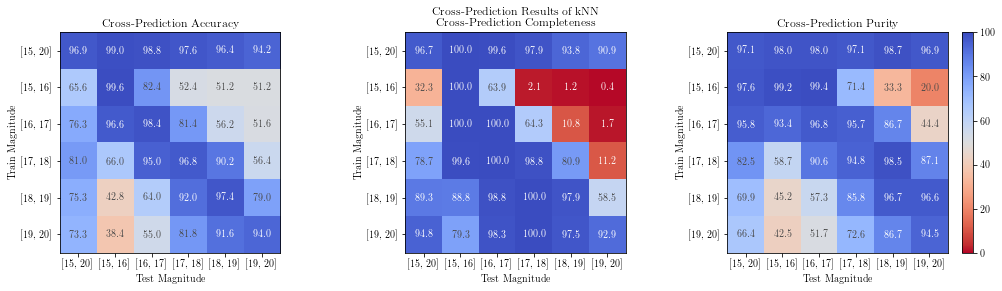

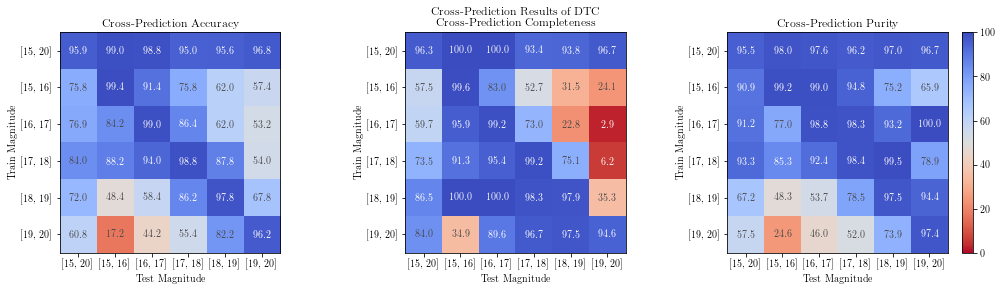

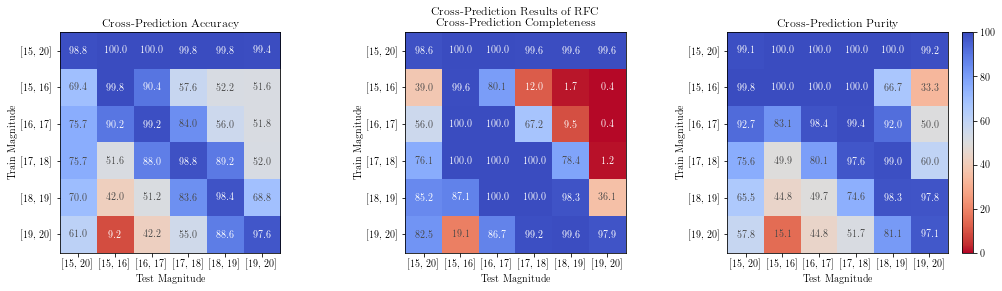

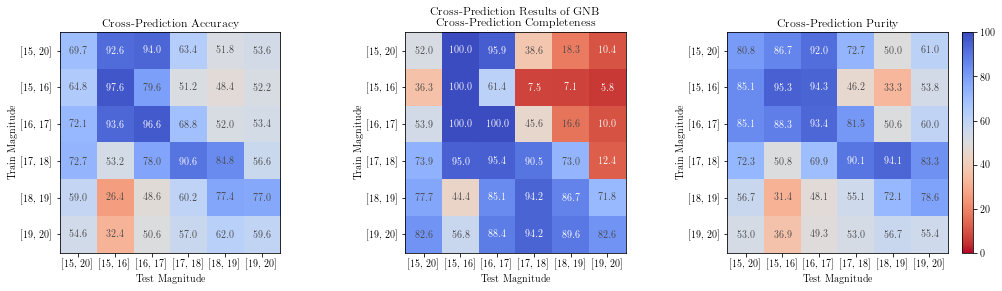

In [18]:
for i in range(5):
    mat_metric = mat_metric_lst[i, :]
    plot_metrics(mat_metric, name_lst[i])

## Performance on Different Models

From the cross-prediction results above, we can compare performance between models. Here we plot the performance verses magnitude for every models training and testing individually on the same dataset, which is the diagonal of each cross-prediction matrix above. 

Overall, the 

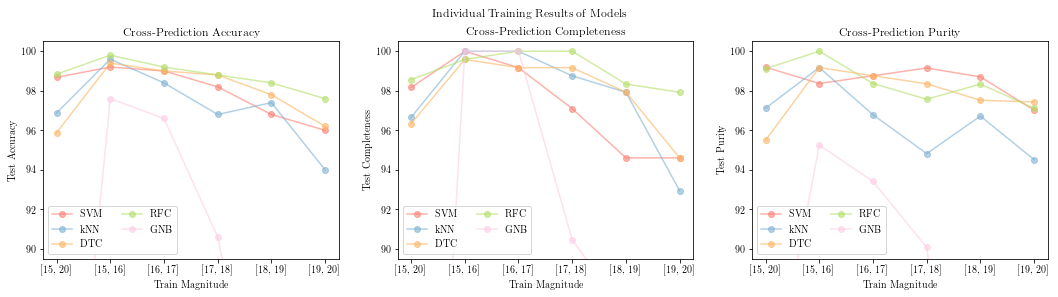

In [19]:
cmap = plt.cm.Set3(np.arange(3, 8))

fig, (ax_a, ax_c, ax_p) = plt.subplots(1, 3, figsize=(18, 4))
fig.subplots_adjust(wspace = 0.2, hspace = 0.4)
fig.suptitle('Individual Training Results of Models', y=0.9999, fontweight='bold')

for i in range(5):
    p_a, p_c, p_p = mat_metric_lst[i, :, :, 0].diagonal(), mat_metric_lst[i, :, :, 1].diagonal(), mat_metric_lst[i, :, :, 2].diagonal()
    ax_a.plot(np.arange(6), p_a, 'o-', alpha=0.6,
              c=cmap[i], label=name_lst[i])
    ax_c.plot(np.arange(6), p_c, 'o-', alpha=0.6,
              c=cmap[i], label=name_lst[i])
    ax_p.plot(np.arange(6), p_p, 'o-', alpha=0.6,
              c=cmap[i], label=name_lst[i])
    
ax_a.set(xticks=np.arange(6), xticklabels=label, 
         ylim=[89.5, 100.5],
         title='Cross-Prediction Accuracy',
         ylabel='Test Accuracy', xlabel='Train Magnitude')
ax_a.legend(loc=3, ncol=2)
ax_c.set(xticks=np.arange(6), xticklabels=label, 
         ylim=[89.5, 100.5],
         title='Cross-Prediction Completeness',
         ylabel='Test Completeness', xlabel='Train Magnitude')
ax_c.legend(loc=3, ncol=2)
ax_p.set(xticks=np.arange(6), xticklabels=label, 
         ylim=[89.5, 100.5],
         title='Cross-Prediction Purity',
         ylabel='Test Purity', xlabel='Train Magnitude')
ax_p.legend(loc=3, ncol=2)

We also print the proformance of models trained on the whole dataset and tested on different groups, i.e. the first rows in former cross-prediction matrixs. 

It 

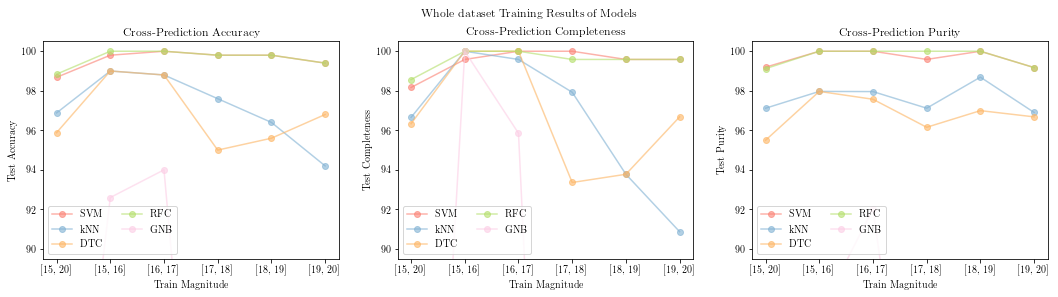

In [20]:
cmap = plt.cm.Set3(np.arange(3, 8))

fig, (ax_a, ax_c, ax_p) = plt.subplots(1, 3, figsize=(18, 4))
fig.subplots_adjust(wspace = 0.2, hspace = 0.4)
fig.suptitle('Whole dataset Training Results of Models', y=0.9999, fontweight='bold')

for i in range(5):
    p_a, p_c, p_p = mat_metric_lst[i, 0, :, 0], mat_metric_lst[i, 0, :, 1], mat_metric_lst[i, 0, :, 2]
    ax_a.plot(np.arange(6), p_a, 'o-', alpha=0.6,
              c=cmap[i], label=name_lst[i])
    ax_c.plot(np.arange(6), p_c, 'o-', alpha=0.6,
              c=cmap[i], label=name_lst[i])
    ax_p.plot(np.arange(6), p_p, 'o-', alpha=0.6,
              c=cmap[i], label=name_lst[i])
    
ax_a.set(xticks=np.arange(6), xticklabels=label, 
         ylim=[89.5, 100.5],
         title='Cross-Prediction Accuracy',
         ylabel='Test Accuracy', xlabel='Train Magnitude')
ax_a.legend(loc=3, ncol=2)
ax_c.set(xticks=np.arange(6), xticklabels=label, 
         ylim=[89.5, 100.5],
         title='Cross-Prediction Completeness',
         ylabel='Test Completeness', xlabel='Train Magnitude')
ax_c.legend(loc=3, ncol=2)
ax_p.set(xticks=np.arange(6), xticklabels=label, 
         ylim=[89.5, 100.5],
         title='Cross-Prediction Purity',
         ylabel='Test Purity', xlabel='Train Magnitude')
ax_p.legend(loc=3, ncol=2)

## Performance on Single Dataset

We look specifically into the model performance on each single datasets. We use one model to conduct individual training and testing processes on six magnitude groups, i.e., the whole dataset and five subsets of magnitude range with $1.0$ magnitude step. We evaluate the predicting performance by confusion matrix. We adopt the matrix in the form without normalization for a more direct view. To illustrate below, we use Random Forest Classifier, which is the most accurate classifier overall, as an example. 

As magnitude decrease, the 

In [22]:
label = lambda y: 'Galaxy' if y else 'Star'

clf = clf_lst[3]
mat_conf_lst = np.empty((6, 2, 2))
x_wr_lst, y_wr_lst, y_pred_wr_lst = [], [], []

for data_i in range(6):
    if data_i == 0:
        f, d = load_data_all()
    else:
        f, d = load_data(14 + data_i)
    x_tr, x_ts, y_tr, y_ts = load_sample(f, d, random_state=42)

#     print('data_i =', data_i)
    clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_ts)
    
    # save confusion matrix
    mat_conf_lst[data_i, :] = sklearn.metrics.confusion_matrix(y_ts, y_pred, labels=range(2))
    
    # save one example for printing below
    idx_lst = (y_pred != y_ts)
    assert len(np.nonzero(idx_lst)) > 0, 'Perfect Model!'
    idx = np.nonzero(idx_lst)[0][0]
    x_wr_lst.append(x_ts[idx].reshape((32, 32, 3)).astype(uint8))
    y_wr_lst.append(label(y_ts[idx]))
    y_pred_wr_lst.append(label(y_pred[idx]))

We visualize the matrixs by following codes. 

In [23]:
cmap = plt.cm.Blues
ctext = lambda x: 'w' if (x > 50) else (72/256,72/256,72/256)
mname = ['[15, 20]'] + [('[%d, %d]' % (mag, mag+1)) for mag in range(15, 20)]
label = ['Star', 'Galaxy']
pre = [['$T_s$', '$F_s$'], 
       ['$F_g$', '$T_g$']]

def plot_confusion(mat_conf, ax, mag):
    img = ax.imshow(mat_conf, interpolation='nearest', cmap=cmap)
    A, C, P = metric(mat_conf)
    
    # set labels
    ax.set(xticks=np.arange(2), yticks=np.arange(2),
           xticklabels=label, yticklabels=label,
           title='$mag$=%s \n $A$=%0.1f, $C$=%0.1f, $P$=%0.1f' % (mag, A, C, P),
           ylabel='True Label', xlabel='Predicted Label')
    # set annotations 
    for i in range(2):
        for j in range(2):
            ax.text(j, i, pre[i][j] + '=' + format(mat_conf[i, j], '0.0f'),
                    ha='center', va='center',
                    color=ctext(mat_conf[i, j]))
    
    return img

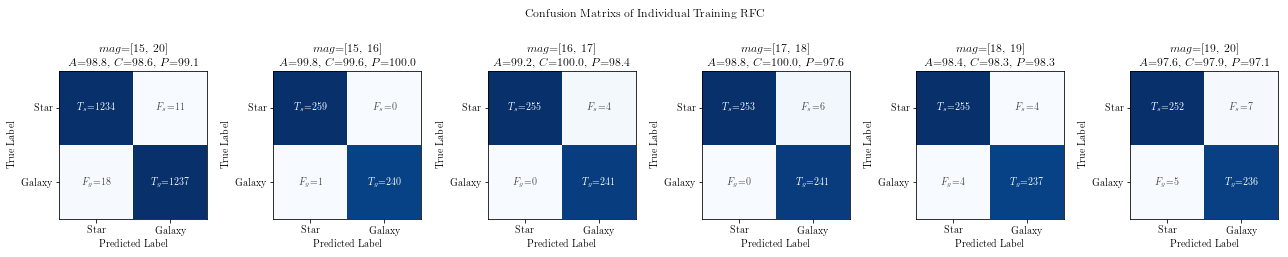

In [24]:
fig, ax = plt.subplots(1, 6, figsize=(18, 4))
fig.subplots_adjust(wspace = 0.2, hspace = 0.4)
fig.suptitle('Confusion Matrixs of Individual Training RFC', fontweight='bold')

for data_i in range(6):
    mat_conf = mat_conf_lst[data_i, :]
    img = plot_confusion(mat_conf, ax[data_i], mname[data_i])
    
fig.tight_layout()
plt.show()

Here are examples of images and predicted labels in each group. 

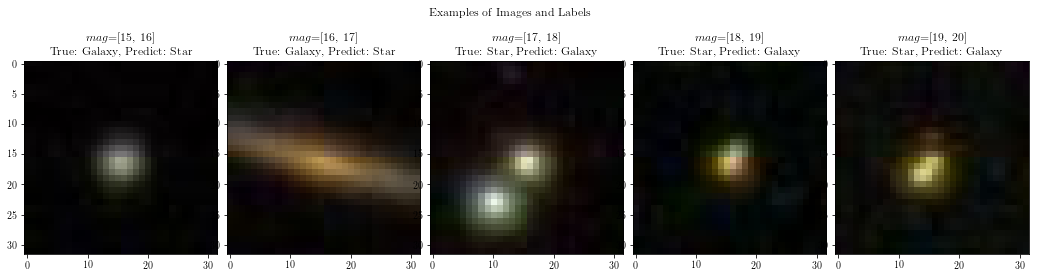

In [25]:
# prepare figure
fig, axs = plt.subplots(1, 5, figsize=(18, 5))
fig.subplots_adjust(hspace = 0.2, wspace = 0.05)
fig.suptitle('Examples of Images and Labels', y=0.92)

for data_i in range(5):
    axs[data_i].imshow(x_wr_lst[data_i])
    axs[data_i].set_title('$mag$=[%d, %d] \n True: %s, Predict: %s' % (data_i+15, data_i+16, y_wr_lst[data_i], y_pred_wr_lst[data_i]))

# Conclusion and Discussion
---

In this work, 